In [1]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
import os
import torch
import csv
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

In [2]:
KITTI_CLASS = ['none','Car','Cyclist','Misc','Pedestrian','Person_sitting','Tram','Truck','Van']#'DontCare'
class KittiDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms, path_img, path_label):
        self.root = root
        self.transforms = transforms
        self.path_img = path_img
        self.path_label = path_label
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, path_img))))
        self.jsons = list(sorted(os.listdir(os.path.join(root, path_label))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, self.path_img, self.imgs[idx])
        csv_file = self.imgs[idx].split(".")[0] + '.txt'
        csv_path = os.path.join(self.root, self.path_label, csv_file)
        if not os.path.exists(csv_path):
            print(csv_path + ' doesnt exist')
            raise Exception(csv_path + ' doesnt exist')
        csv_file = csv.reader(open(csv_path, 'r'), delimiter=' ')
        box_list = []
        label_list = []
        for r in csv_file:
            truncated = r[1]
            occluded = r[2]
            alpha = r[3]
            x1 = float(r[4])
            y1 = float(r[5])
            x2 = float(r[6])
            y2 = float(r[7])
            dim_1 = r[8]
            dim_2 = r[9]
            dim_3 = r[10]
            loc_1 = r[11]
            loc_2 = r[12]
            loc_3 = r[13]
            rot = r[14]
            if r[0] == 'DontCare':
                continue
            box = []
            box.append(x1)
            box.append(y1)
            box.append(x2)
            box.append(y2)
            degenerate_box = box[2] <= box[0] or box[3] <= box[1]
            if degenerate_box:
                print("degenerate {} {} {} {} {} {} ".format(box[0] , box[1], box[2], box[3], box[2] <= box[0], box[3] <= box[1]))
                continue
            label_list.append(KITTI_CLASS.index(r[0]))
            box_list.append(box)
        img = read_image(img_path)
        # get bounding box coordinates for each mask
        boxes = torch.tensor(box_list)

        # there is only one class
        labels = torch.tensor(label_list, dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(box_list),), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
from torchvision.transforms import v2 as T
def get_transform(train):
    transforms = []
    # if train:
    #     transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.Resize((376,1242)))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [4]:
import utils
#CUDA_LAUNCH_BLOCKING=1
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 9
def get_data_loader(path_img="KITTI/img/training/image_2",
                    path_label="KITTI/label/training/label_2",
                    path_test = "KITTI/img/training/test"):
    # use our dataset and defined transformations
    dataset_train = KittiDataset('./', get_transform(train=True), path_img=path_img,
                           path_label=path_label)
    dataset_test = KittiDataset('./', get_transform(train=True), path_img=path_test,
                           path_label=path_label)
    
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=2,
        shuffle=False,
        collate_fn=utils.collate_fn
    )
    
    data_loader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=1,
        shuffle=False,
        collate_fn=utils.collate_fn
    )
    return data_loader, data_loader_test


In [5]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
def print_test_image(model):
    image = read_image("./KITTI/img/training/image_2/000025.png")
    eval_transform = get_transform(train=False)
    
    model.eval()
    with torch.no_grad():
        x = eval_transform(image)
        # convert RGBA -> RGB and move to device
        x = x[:3, ...].to(device)
        predictions = model([x, ])
        pred = predictions[0]
    
    image = (255.0 * (image) / (image.max())).to(torch.uint8)
    image = image[:3, ...]
    pred_labels = [f"{KITTI_CLASS[label]}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
    pred_boxes = pred["boxes"].long()
    output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="white")
    
    #masks = (pred["masks"] > 0.7).squeeze(1)
    #output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")
    
    
    plt.figure(figsize=(12, 12))
    plt.imshow(output_image.permute(1, 2, 0))

In [6]:
import torch.nn as nn
from torch import Tensor
from collections import OrderedDict
class Conv2dNormRelu(nn.Module):
    def __init__(self, in_channel, out_channel, size, stride, padding, device):
        super().__init__()
        self.l1 = nn.Conv2d(in_channel, out_channel, size, stride, padding,  device=device)
        self.l2 = nn.BatchNorm2d(out_channel, device=device)
        self.l3 = nn.ReLU(inplace=True)
        nn.init.xavier_uniform_(self.l1.weight)
    def forward(self, x: Tensor) -> Tensor:
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x

In [7]:
class FastRCNNPredictorV2(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.cls_score = nn.Linear(in_channels, num_classes)
        self.c1 = nn.Linear(in_channels, in_channels*2)
        self.c2 = nn.Linear(in_channels*2, in_channels)
        self.c3 = nn.Dropout(p=0.5)
        self.b1 = nn.Linear(in_channels, in_channels*2)
        self.b2 = nn.Linear(in_channels*2, in_channels)
        self.b3 = nn.Dropout(p=0.5)
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4)

    def forward(self, x):
        if x.dim() == 4:
            torch._assert(
                list(x.shape[2:]) == [1, 1],
                f"x has the wrong shape, expecting the last two dimensions to be [1,1] instead of {list(x.shape[2:])}",
            )
        x = x.flatten(start_dim=1)
        scores = self.c1(x)
        scores = self.c2(scores)
        scores = self.c3(scores)
        scores = self.cls_score(scores)

        bbox_deltas = self.b1(x)
        bbox_deltas = self.b2(bbox_deltas)
        bbox_deltas = self.b3(bbox_deltas)        
        bbox_deltas = self.bbox_pred(bbox_deltas)

        return scores, bbox_deltas

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FasterRCNN, FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor
from torchvision.models.resnet import resnet50, ResNet50_Weights
from torchvision.ops import misc as misc_nn_ops
from torchvision.models.detection.rpn import RegionProposalNetwork, RPNHead
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.transform import GeneralizedRCNNTransform
def make_rcnn(backbone, num_classes, out_channels, min_size = 376, max_size = 1242,
              image_mean = [0.0 , 0.0, 0.0], image_std = [1, 1, 1], box_score_thresh = 0.1, Predictor = FastRCNNPredictorV2):
    anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    rpn_anchor_generator  = AnchorGenerator(anchor_sizes, aspect_ratios)
    rpn_head = RPNHead(out_channels, rpn_anchor_generator.num_anchors_per_location()[0],3)
    model = FasterRCNN(backbone, num_classes=num_classes, rpn_head=rpn_head,
                       min_size = min_size, max_size = max_size,
                       image_mean = image_mean, image_std = image_std, box_score_thresh = box_score_thresh)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = Predictor(in_features, num_classes)

    return model

In [9]:

class CustomBackbone(nn.Module):
    def __init__(
        self):
        super().__init__()
        self.l1 = Conv2dNormRelu(3, 64, 7, 2, 3,  device=device)
        self.l2 = Conv2dNormRelu(64, 64, 3, 2, 1,  device=device)
        self.l3 = Conv2dNormRelu(64, 128, 3, 1, 1,  device=device)
        self.l4 = Conv2dNormRelu(128, 128, 3, 1, 1,  device=device)
        
        self.l5 = Conv2dNormRelu(128, 128, 3, 2, 1,  device=device)
        self.l6 = Conv2dNormRelu(128, 128, 3, 2, 1,  device=device)
        self.l7 = Conv2dNormRelu(128, 128, 3, 2, 1,  device=device)        
        self.l8 = Conv2dNormRelu(128, 128, 3, 2, 1,  device=device)
        
        self.out_channels = 128
        self.inplanes = 128
    def forward(self, x: Tensor) -> Tensor:
        result = OrderedDict()
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out = self.l4(out)
        result['0'] = out
        out = self.l5(out)
        result['1'] = out
        out = self.l6(out)
        result['2'] = out
        out = self.l7(out)
        result['3'] = out
        out = self.l8(out)
        result['pool'] = out
        return result

In [10]:
from typing import Optional
import utils
from engine import train_one_epoch, evaluate
class RCNNWithCustomBackbone():
    def __init__(self):
        super().__init__()
        self.backbone = CustomBackbone()
        self.rcnn = make_rcnn(self.backbone, num_classes, 128, min_size = 376, max_size = 1242,
                  image_mean = [0.0 , 0.0, 0.0], image_std = [1, 1, 1], box_score_thresh = 0.1, Predictor = FastRCNNPredictorV2)
        self.rcnn.to(device)
        data_loader, data_loader_test = get_data_loader()
        self.data_loader = data_loader
        self.data_loader_test = data_loader_test
        
    def save_model(self, name = './kitti_fasterrcnn_custom_backbone_rcnn'):
        torch.save(self.rcnn.state_dict(), name)
    def load_model(self, name = './kitti_fasterrcnn_custom_backbone_rcnn'):
        self.rcnn.load_state_dict(torch.load(name, weights_only=True))
    
    def train_main(self, data_loader, data_loader_test, num_epochs = 1, lr=0.0001):
        params = [p for p in self.rcnn.parameters() if p.requires_grad]
        optimizer = torch.optim.Adam(params,lr,)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
        
        for epoch in range(num_epochs):
            # train for one epoch, printing every 10 iterations
            train_one_epoch(self.rcnn, optimizer, data_loader, device, epoch, print_freq=10)
            # update the learning rate
            lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(self.rcnn, data_loader_test, device=device)
    def train(self, num_epochs = 1, lr=0.0001):
        self.train_main(self.data_loader, self.data_loader_test, num_epochs, lr)

In [11]:
detect_model = RCNNWithCustomBackbone()

In [39]:
detect_model.train(num_epochs = 10,lr=0.0001)

Epoch: [0]  [   0/3367]  eta: 2:30:24  lr: 0.000000  loss: 2.9107 (2.9107)  loss_classifier: 2.1755 (2.1755)  loss_box_reg: 0.0137 (0.0137)  loss_objectness: 0.6932 (0.6932)  loss_rpn_box_reg: 0.0282 (0.0282)  time: 2.6803  data: 0.0201  max mem: 945
Epoch: [0]  [  10/3367]  eta: 0:28:33  lr: 0.000001  loss: 2.9092 (2.9101)  loss_classifier: 2.1712 (2.1653)  loss_box_reg: 0.0178 (0.0240)  loss_objectness: 0.6932 (0.6932)  loss_rpn_box_reg: 0.0282 (0.0277)  time: 0.5103  data: 0.1044  max mem: 1079
Epoch: [0]  [  20/3367]  eta: 0:22:15  lr: 0.000002  loss: 2.8952 (2.9035)  loss_classifier: 2.1447 (2.1364)  loss_box_reg: 0.0357 (0.0388)  loss_objectness: 0.6932 (0.6932)  loss_rpn_box_reg: 0.0219 (0.0351)  time: 0.2850  data: 0.1096  max mem: 1079
Epoch: [0]  [  30/3367]  eta: 0:19:48  lr: 0.000003  loss: 2.8351 (2.8614)  loss_classifier: 2.0495 (2.0900)  loss_box_reg: 0.0546 (0.0427)  loss_objectness: 0.6931 (0.6931)  loss_rpn_box_reg: 0.0265 (0.0356)  time: 0.2712  data: 0.1060  max mem

KeyboardInterrupt: 

In [ ]:
detect_model.save_model()

In [12]:
detect_model.load_model()

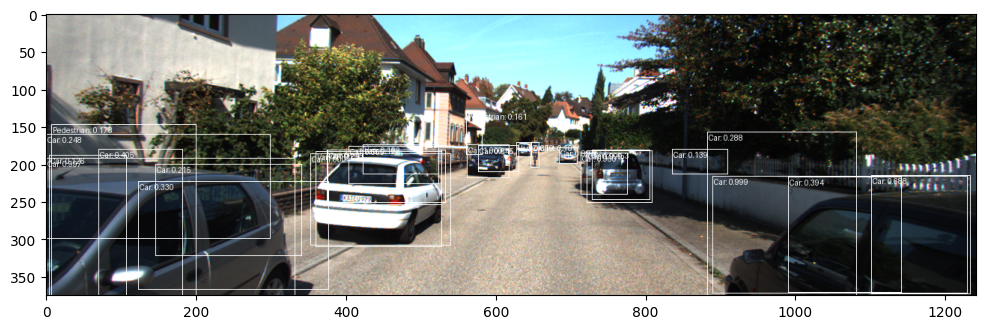

In [13]:
print_test_image(detect_model.rcnn)